# Import relevant modules and data

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load personal loan data into a Pandas DataFrame from the given file
df_loan_data = pd.read_excel('personal-loan.xls', index_col = 0, header = 1)

In [3]:
# Load the data dictionary into a Pandas DataFrame from the given file
df_data_dict = pd.read_excel('data-dictionary.xlsx', index_col = 0)
df_data_dict.set_index('Field', drop = True, inplace = True)

# Explore missing values in personal loan data

In [4]:
# Assign all "empty" fields as NaNs and remove completely empty rows
df_loan_data.replace(' ', float('nan'), inplace = True)
df_loan_data.dropna(how = 'all', inplace = True)

In [5]:
# Determine which columns contain NaN values
nan_cols = df_loan_data.columns[df_loan_data.isna().any()].to_list()

In [6]:
# Check the target column 'personal_loan' is not in nan_cols
nan_cols

['age', 'yrs_experience', 'family_size', 'income']

In [7]:
# For the target column 'personal_loan', re-cast 'yes' = 1, 'no' = 0
replace_dict = {'yes' : 1, 'no' : 0}
df_loan_data['personal_loan'] = df_loan_data['personal_loan'].replace(replace_dict)

In [8]:
# For columns containing NaN values:
# Figure out the proportion of NaNs in each column & how they relate to the target
for col in nan_cols:
    
    num_values = df_loan_data.shape[0]
    frac_nans = df_loan_data[col].isna().sum() / num_values
    loans_nans_only = df_loan_data.loc[df_loan_data[col].isna() == True, 'personal_loan']
    loans_no_nans = df_loan_data.loc[df_loan_data[col].isna() == False, 'personal_loan']
    loans_nans_pct = np.round(loans_nans_only.mean()*100, 1)
    loans_nonans_pct = np.round(loans_no_nans.mean()*100, 1)
    
    print('Column "{}" is made up of {}% NaN values'.format(col, np.round(frac_nans*100, 1)))
    print('When {} = NaN, {}% of customers recieve loans'.format(col, loans_nans_pct))
    print('When {} != NaN, {}% of customers recieve loans'.format(col, loans_nonans_pct))
    print('------------------')

Column "age" is made up of 6.3% NaN values
When age = NaN, 0.0% of customers recieve loans
When age != NaN, 16.0% of customers recieve loans
------------------
Column "yrs_experience" is made up of 6.1% NaN values
When yrs_experience = NaN, 0.0% of customers recieve loans
When yrs_experience != NaN, 16.0% of customers recieve loans
------------------
Column "family_size" is made up of 6.4% NaN values
When family_size = NaN, 0.0% of customers recieve loans
When family_size != NaN, 16.0% of customers recieve loans
------------------
Column "income" is made up of 6.3% NaN values
When income = NaN, 0.0% of customers recieve loans
When income != NaN, 16.0% of customers recieve loans
------------------


The above findings indicate that NaNs only occur when a loan was not processed.

We would therefore not want to predict based on any of these rows, as this would be an instance of target leakage, so they should be dropped.

I.e. It seems to be that when *any* field is NaN, it is **BECAUSE** target == 0. To use any such data points in prediction would therefore provide skewed results

In [9]:
# Remove all rows containing any NaN values based on above analysis
df_loan_data.dropna(how = 'any', inplace = True)

In [10]:
# Cast columns that should be integers as such
for col in df_loan_data.columns:
    if is_float_dtype(df_loan_data[col]) == True:
        if col != 'credit_card_spend':
            df_loan_data[col] = df_loan_data[col].astype(int)

# Visualize the relationships between variables

In [11]:
# Generate some summary statistics
print('Summary statistics:')
df_loan_data.describe()

Summary statistics:


,age,yrs_experience,family_size,income,mortgage_amt,credit_card_spend,share_trading_acct,fixed_deposit_acct,personal_loan
count,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,45.046580,20.602033,2.421442,86.360259,68.638447,0.593530,0.098521,0.082994,0.166359
std,12.551335,12.419831,1.138505,45.416852,88.943678,1.332406,0.298046,0.275899,0.372437
min,23.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,10.000000,1.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,21.000000,2.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,31.000000,3.000000,117.000000,126.000000,0.400000,0.000000,0.000000,0.000000
max,92.000000,64.000000,7.000000,223.000000,617.000000,9.500000,1.000000,1.000000,1.000000


On average, 16.64 percent of customers took a loan


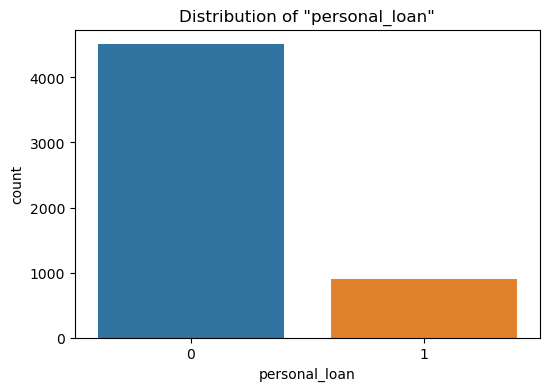

In [12]:
# Visualize the distribution of the target variable 'personal_loan'
target_variable = 'personal_loan'
loan_pct = np.round(df_loan_data[target_variable].mean()*100, 2)
print('On average, {} percent of customers took a loan'.format(loan_pct))
plt.figure(figsize=(6, 4))
sns.countplot(data=df_loan_data, x=target_variable)
plt.title('Distribution of "{}"'.format(target_variable))
plt.show()

In [13]:
# Explore column compositions to help determine categorical vs. numeric columns
for col in df_loan_data.columns:
    unique_values = df_loan_data[col].unique()
    print('Column "{}" contains {} unique values'.format(col, len(unique_values)))
    print('These values are: {}'.format(unique_values))
    print('------------------')

Column "age" contains 47 unique values
These values are: [40 65 61 29 43 44 42 64 25 36 35 26 45 58 31 28 34 67 51 32 27 53 59 49
 33 66 46 37 38 55 63 41 57 47 52 50 30 54 62 23 48 24 56 60 39 92 90]
------------------
Column "yrs_experience" contains 46 unique values
These values are: [ 9 27  3 14 23 18 16 38  7  8 15 13 25 22  1 24 10 11 31  4 19  5 36 33
 37 39 40 34 28  2 17 42 35 29 30  6  0 20 32 21 26 41 12 63 64 62]
------------------
Column "family_size" contains 6 unique values
These values are: [3 4 2 1 7 6]
------------------
Column "education_level" contains 3 unique values
These values are: ['Graduate' 'Advanced or Professional' 'Undergraduate']
------------------
Column "income" contains 211 unique values
These values are: [ 60  36 145  52  33  49  23 112  28  47  40 175  77  58  82  69 149  66
 182 144  79  45 143 172  93 147  94  80  50 121  15  91 174  29  99  48
 100  78 203  74  64 107  44 102 113 106 156  54  37  55  53  87  22   8
  10 135  70 111 164 109  43  72

In [14]:
# Establish numeric and categorical features
categorical_feats = [
    'education_level', 
    'credit_card_acct', 
    'share_trading_acct', 
    'fixed_deposit_acct', 
    'online_acct'
    ]
numeric_feats = [col for col in df_loan_data.columns if col not in categorical_feats + [target_variable]]

## Analyse numeric features

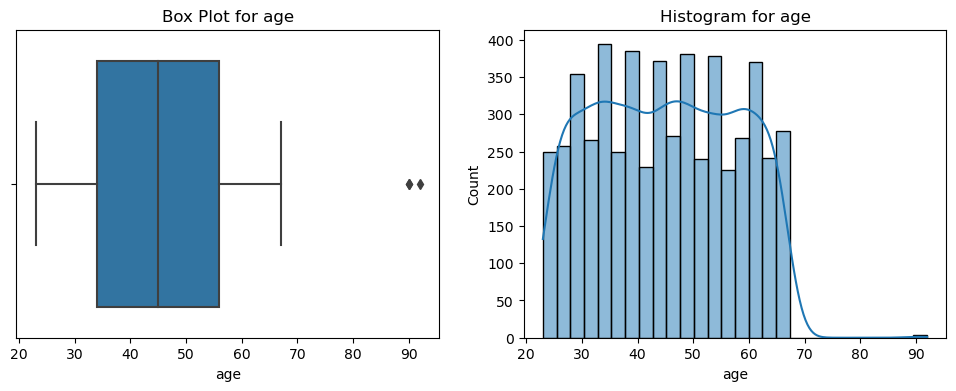

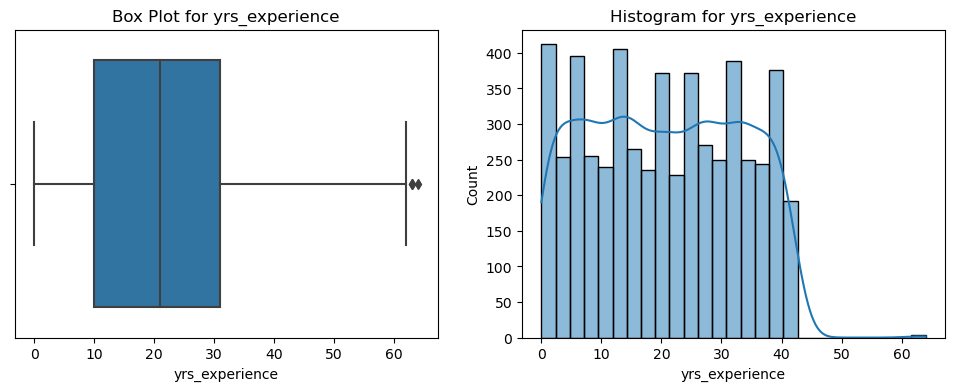

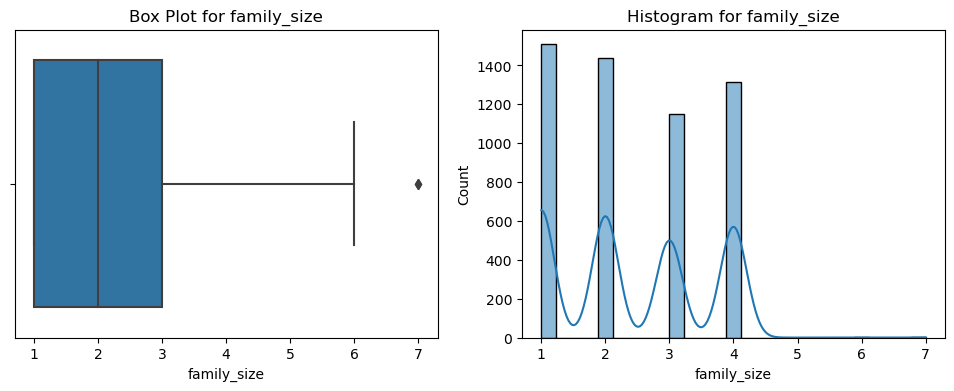

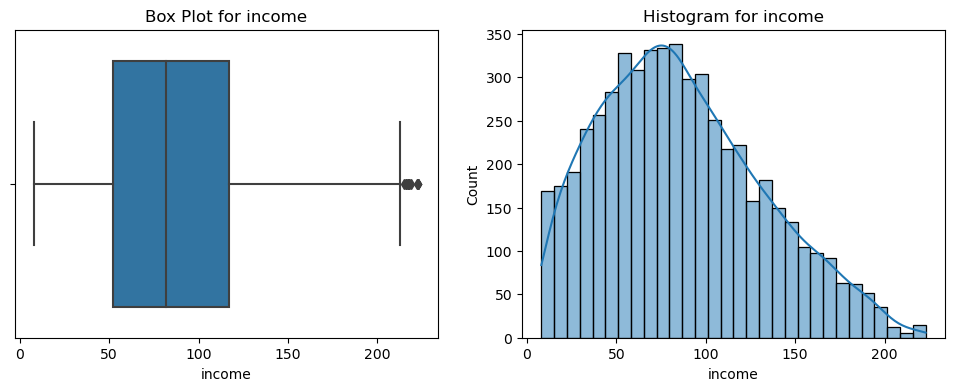

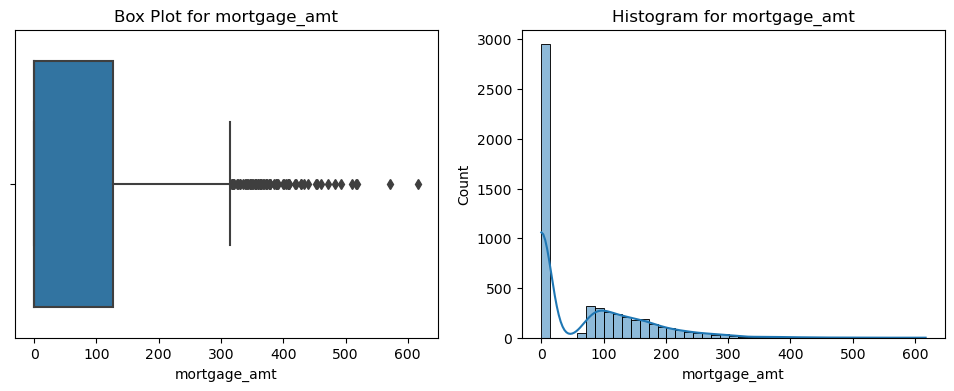

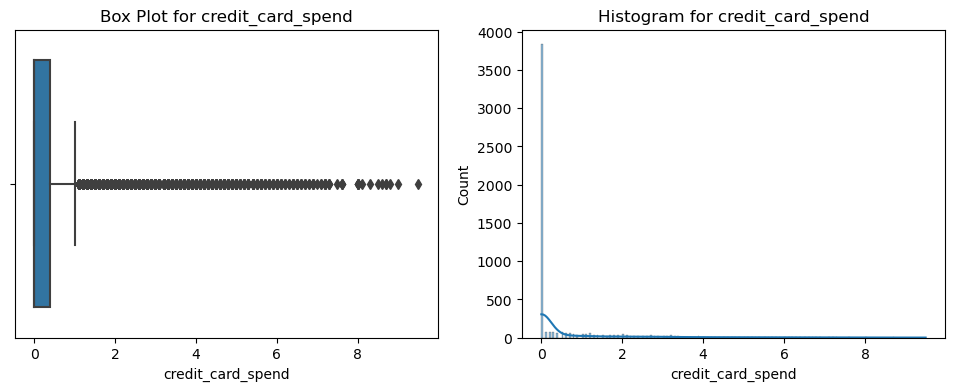

In [15]:
# Check for outliers in numeric features
for feat in numeric_feats:
    
    # Create a new figure
    plt.figure(figsize=(12, 4))

    # Box plot for outlier detection
    plt.subplot(121)
    sns.boxplot(data=df_loan_data, x=feat)
    plt.title('Box Plot for {}'.format(feat))

    # Histogram for distribution visualization
    plt.subplot(122)
    sns.histplot(data=df_loan_data, x=feat, kde=True)
    plt.title('Histogram for {}'.format(feat))

    plt.show()

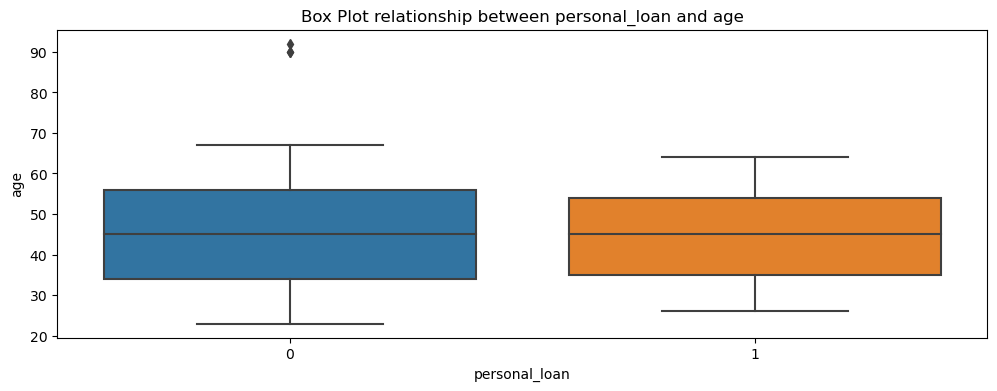

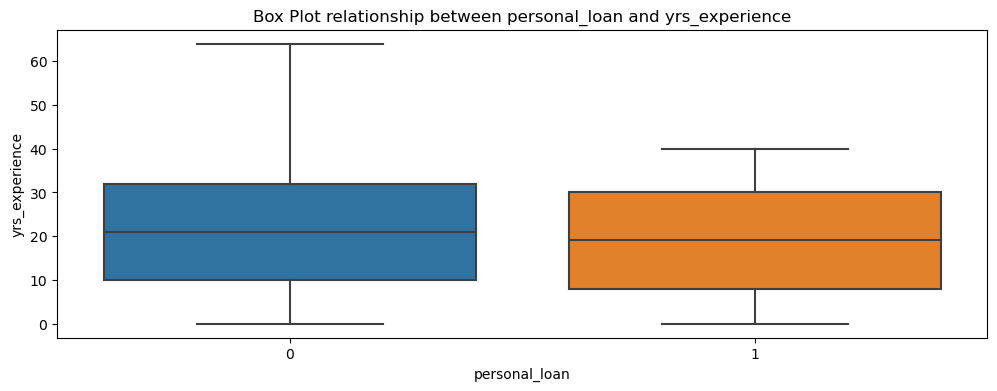

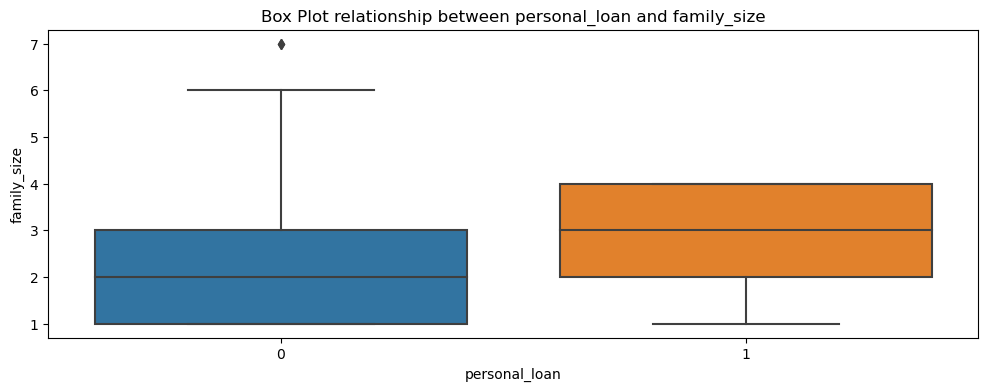

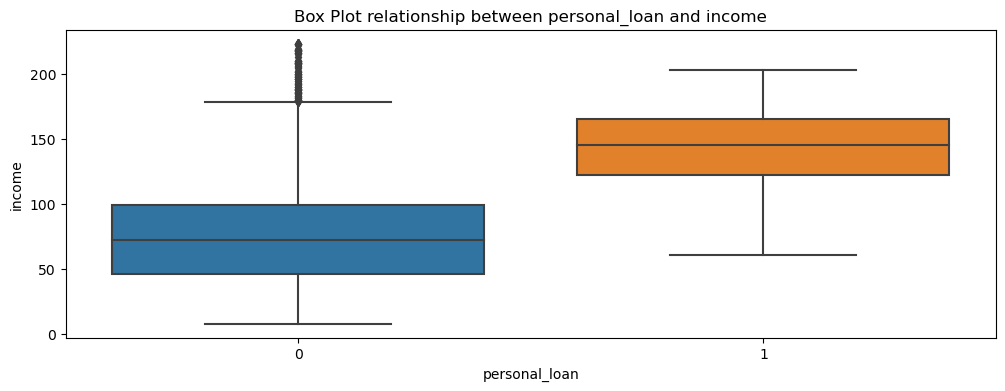

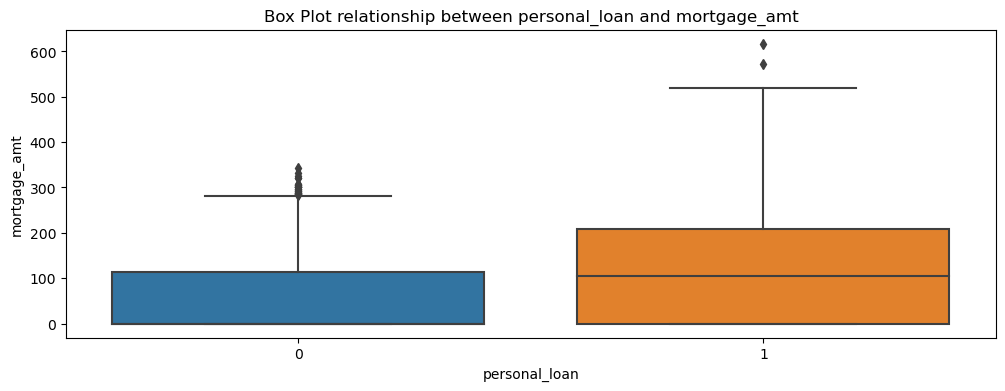

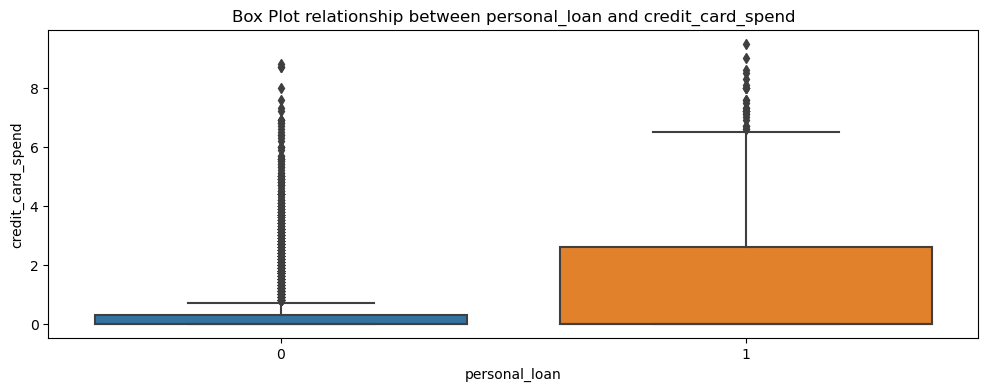

In [16]:
# Analyse the relationship between numeric features and the target
for feat in numeric_feats:
    
    # Create box plot
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df_loan_data, x=target_variable, y=feat)
    plt.title('Box Plot relationship between {} and {}'.format(target_variable, feat))
    plt.show()

### Perscriptive outlier treatments based on analysis:

age:  
- Description: Has very few data points with value > 66
- Treatment: Should be capped at 66 (anything over can be set to 66)

yrs_experience:  
- Description: Has very few data points with value > 42
- Treatment: Should be capped at 42

family_size:  
- Description: Has very few data points with value > 4
- Treatment: Should be capped at 4

income:  
- Normal distribution with no outliers. No treatment needed.

mortgage_amt:
- Description: Dominated by amt = 0 where people don't have a mortgage
- Treatment:  
  - Create a separate catergorical variable 'has_mortgage' yes/no, then...  
  - For mortgage_amt, impute random values where value is = 0
 
credit_card_spend:
- Description: Dominated by spend = 0 where people don't spend
- Treatment:  
  - Create a separate catergorical variable 'has_credit_spend' yes/no, then...  
  - For credit_card_spend, impute random values where value is = 0

In [17]:
# Perform outlier treatments to check if post-transformaton distributions look normal

# Enforce reccomended variable caps
df_loan_data['age'] = df_loan_data['age'].apply(lambda x: min(x, 66))
df_loan_data['yrs_experience'] = df_loan_data['yrs_experience'].apply(lambda x: min(x, 42))
df_loan_data['family_size'] = df_loan_data['family_size'].apply(lambda x: min(x, 4))

# Create reccomended new columns & update categorical_feats
df_loan_data['has_mortgage'] = df_loan_data['mortgage_amt'].apply(lambda x: 0 if x == 0 else 1)
df_loan_data['has_credit_spend'] = df_loan_data['credit_card_spend'].apply(lambda x: 0 if x == 0 else 1)
categorical_feats = categorical_feats + ['has_mortgage', 'has_credit_spend']

# Impute values as reccomended for mortgage_amt
zero_mortgage_indices = df_loan_data['mortgage_amt'] == 0
non_zero_mortgage_values = df_loan_data.loc[~zero_mortgage_indices, 'mortgage_amt']
random_mortgage_sample = np.random.choice(non_zero_mortgage_values, zero_mortgage_indices.sum())
df_loan_data.loc[zero_mortgage_indices, 'mortgage_amt'] = random_mortgage_sample

# Impute values as reccomended for credit_card_spend
zero_cspend_indices = df_loan_data['credit_card_spend'] == 0
non_zero_cspend_values = df_loan_data.loc[~zero_cspend_indices, 'credit_card_spend']
random_cspend_sample = np.random.choice(non_zero_cspend_values, zero_cspend_indices.sum())
df_loan_data.loc[zero_cspend_indices, 'credit_card_spend'] = random_cspend_sample

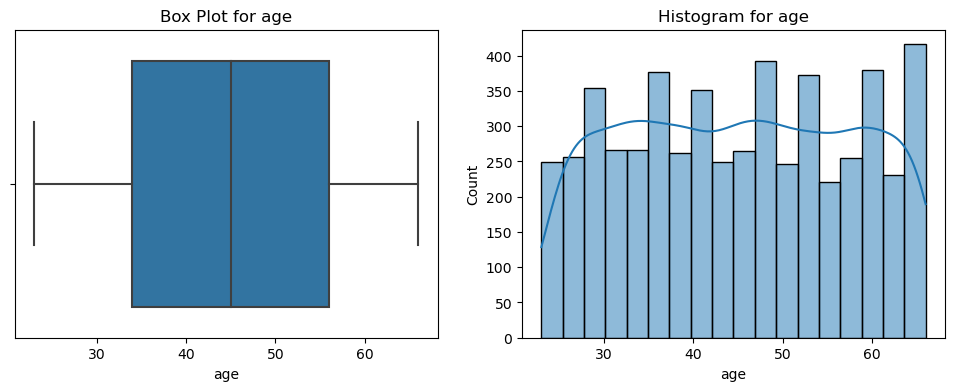

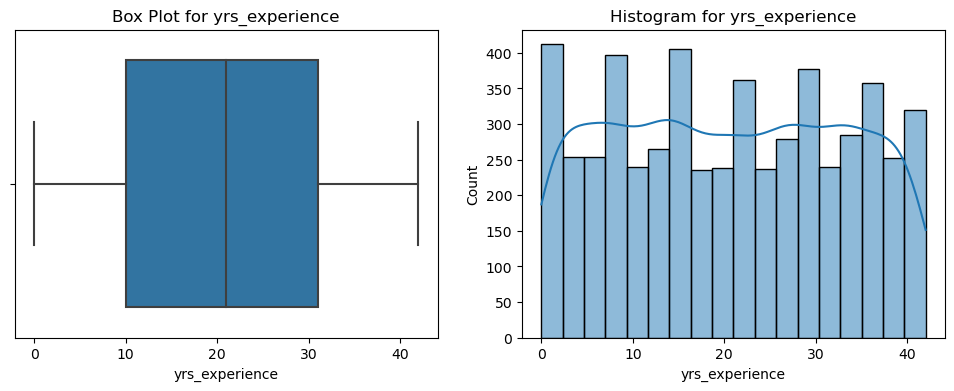

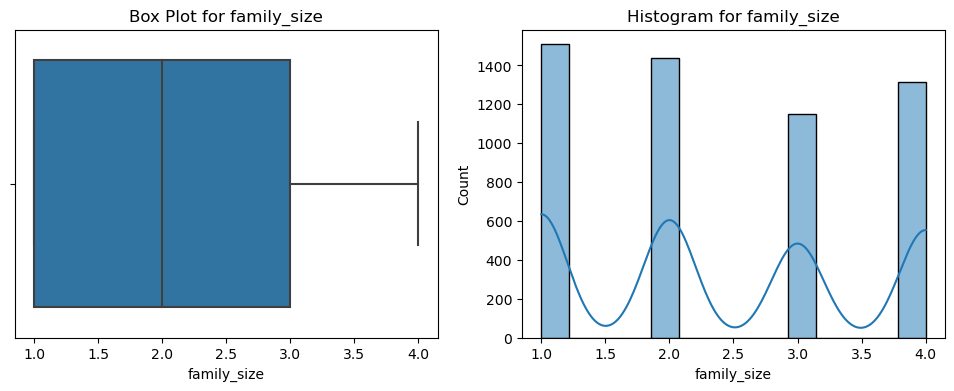

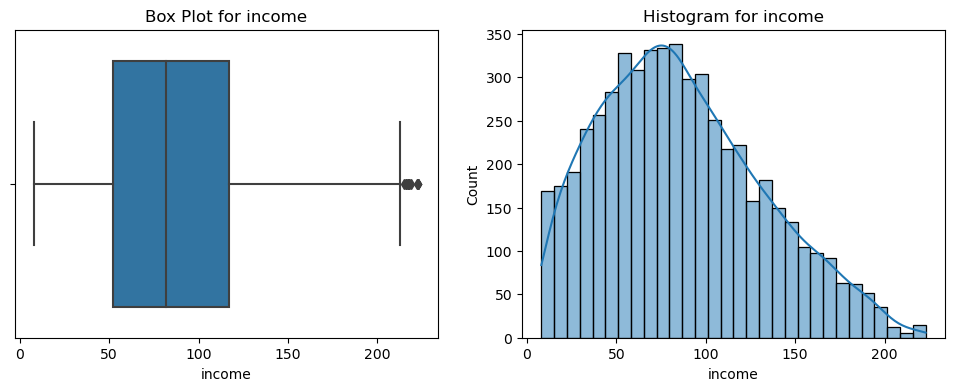

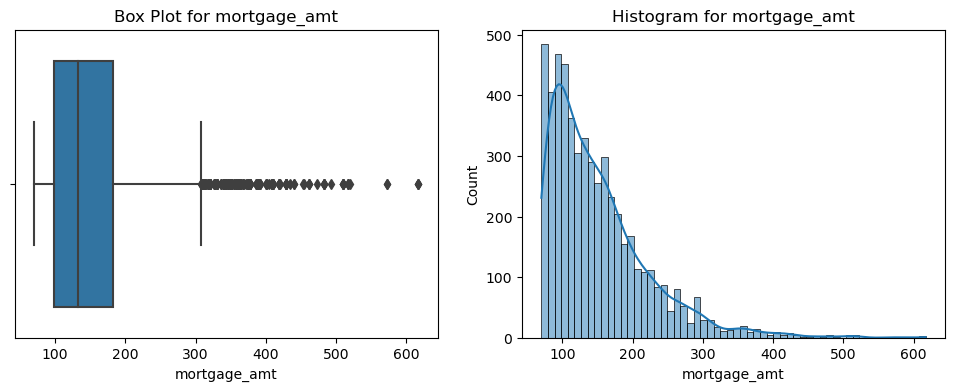

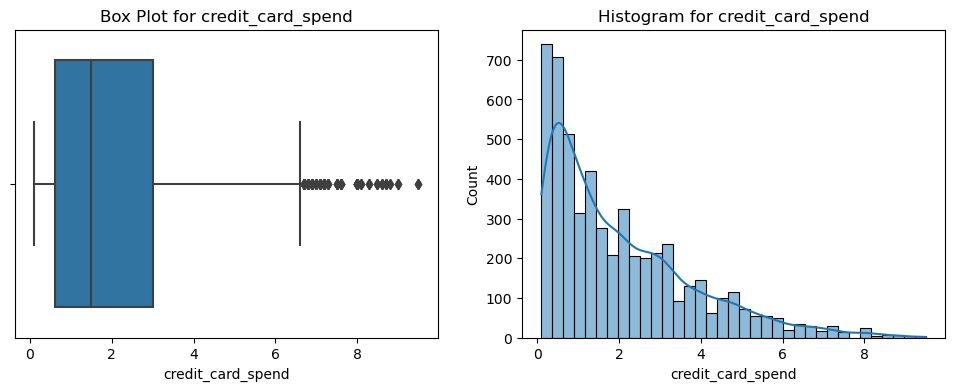

In [18]:
# Visualize transformed numeric variables
for feat in numeric_feats:
    
    # Create a new figure
    plt.figure(figsize=(12, 4))

    # Box plot for outlier detection
    plt.subplot(121)
    sns.boxplot(data=df_loan_data, x=feat)
    plt.title('Box Plot for {}'.format(feat))

    # Histogram for distribution visualization
    plt.subplot(122)
    sns.histplot(data=df_loan_data, x=feat, kde=True)
    plt.title('Histogram for {}'.format(feat))

    plt.show()

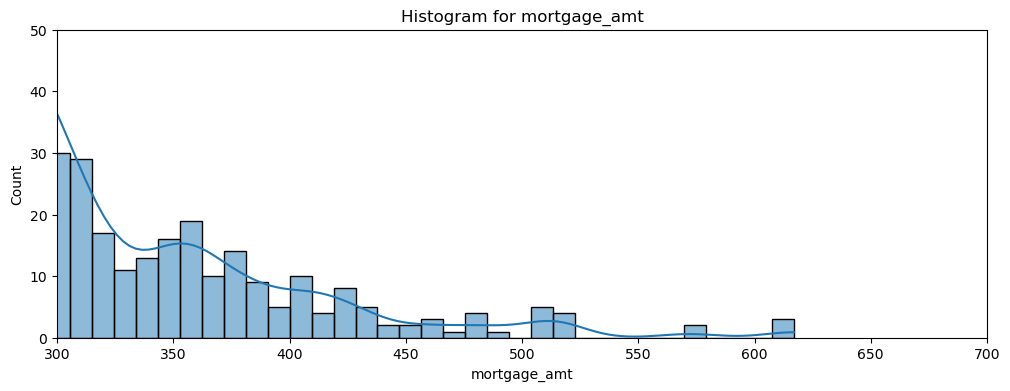

In [19]:
# Focus in on mortgage_amt histogram -- might still have outliers to deal with
plt.figure(figsize=(12, 4))
sns.histplot(data=df_loan_data, x='mortgage_amt', kde=True)
plt.title('Histogram for {}'.format('mortgage_amt'))
plt.xlim([300,700])
plt.ylim([0,50])
plt.show()

# Conclusion: nothing crazy happening here. Can leave alone

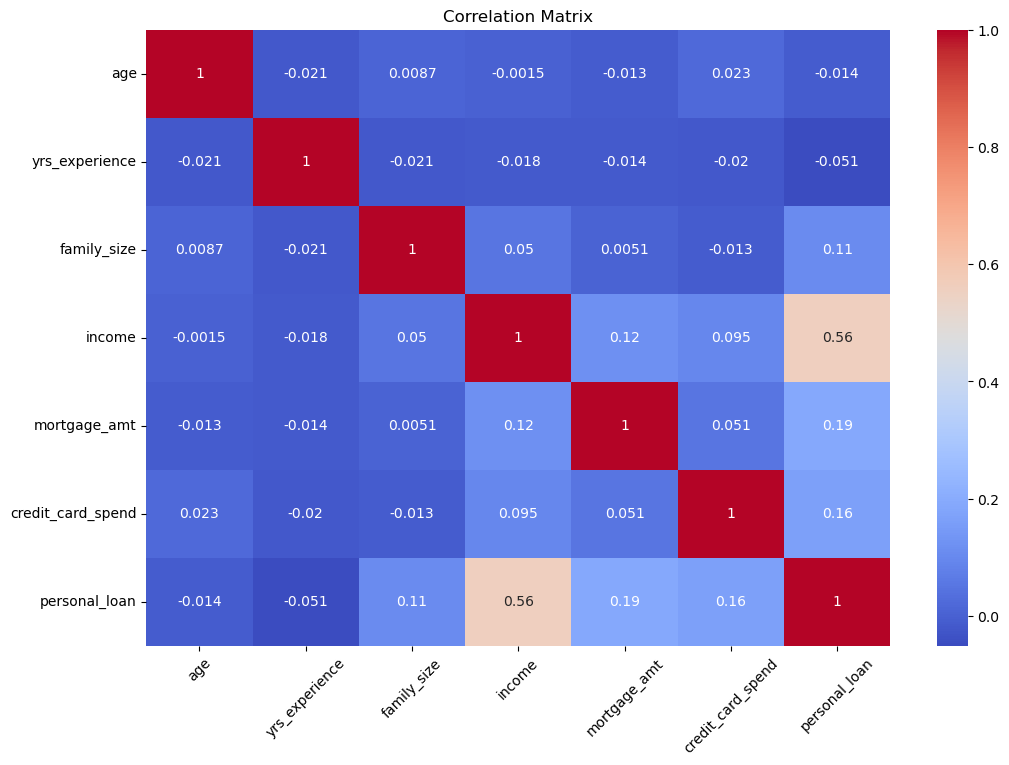

In [20]:
# Explore the correlations between numeric features (and the target)
correlation_matrix = df_loan_data[numeric_feats + [target_variable]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

## Analyse categorical features

In [21]:
# Explore categorical value counts
for feature in categorical_feats:
    print('Value counts for {}:'.format(feature))
    print(df_loan_data[feature].value_counts())
    print('------------------')

Value counts for education_level:
education_level
Undergraduate               2187
Advanced or Professional    1648
Graduate                    1575
Name: count, dtype: int64
------------------
Value counts for credit_card_acct:
credit_card_acct
no     3792
yes    1618
Name: count, dtype: int64
------------------
Value counts for share_trading_acct:
share_trading_acct
0    4877
1     533
Name: count, dtype: int64
------------------
Value counts for fixed_deposit_acct:
fixed_deposit_acct
0    4961
1     449
Name: count, dtype: int64
------------------
Value counts for online_acct:
online_acct
yes    3245
no     2165
Name: count, dtype: int64
------------------
Value counts for has_mortgage:
has_mortgage
0    2949
1    2461
Name: count, dtype: int64
------------------
Value counts for has_credit_spend:
has_credit_spend
0    3834
1    1576
Name: count, dtype: int64
------------------


In [22]:
# Re-cast categorical columns as numerical columns where it makes sense to do so  
# I.e. where there are only two values or an inherent ordering

# Re-cast two-value columns such that 'yes' = 1, and 'no' = 0
two_val_cols = ['online_acct', 'credit_card_acct']
replace_dict = {'yes' : 1, 'no' : 0}
df_loan_data.loc[:, two_val_cols] = df_loan_data.loc[:, two_val_cols].replace(replace_dict)

# Re-cast education_level as a numeric column s.t. increasing value = increasing education
replace_dict = {'Undergraduate' : 0, 'Graduate' : 1, 'Advanced or Professional' : 2}
df_loan_data.loc[:, 'education_level'] = df_loan_data.loc[:, 'education_level'].replace(replace_dict)

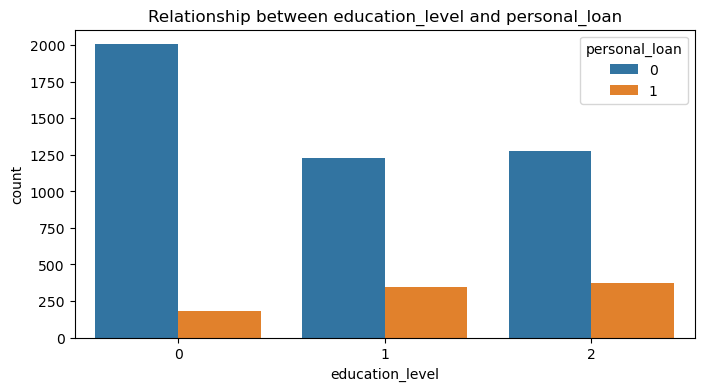

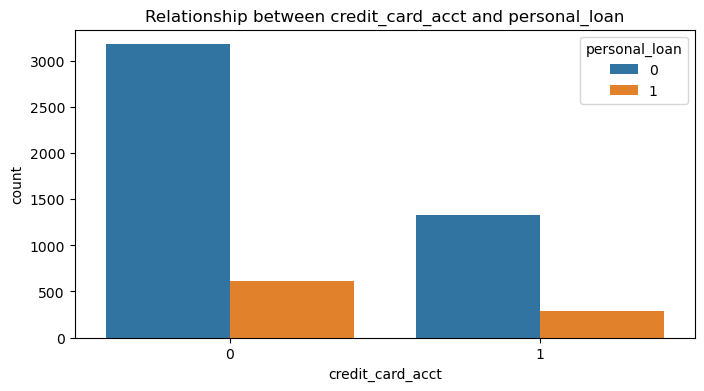

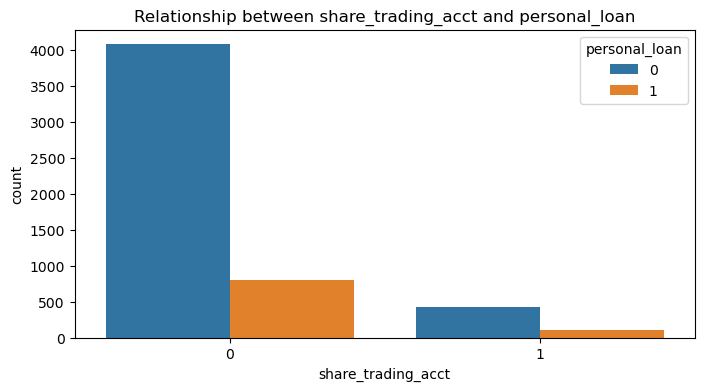

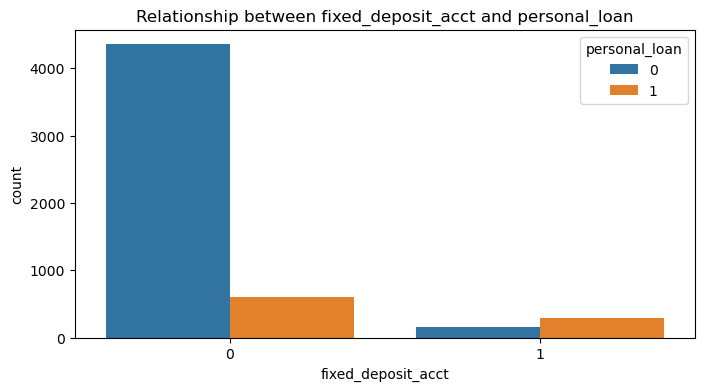

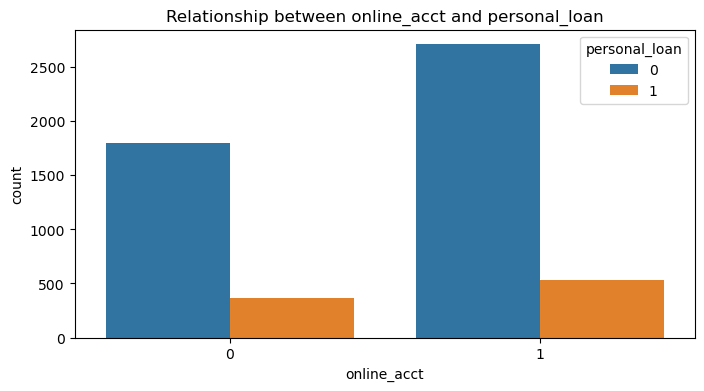

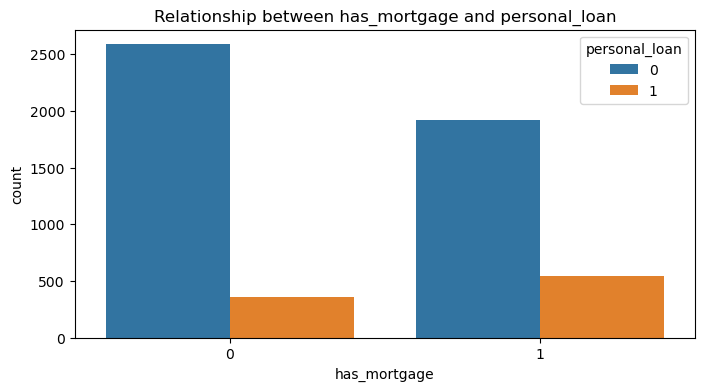

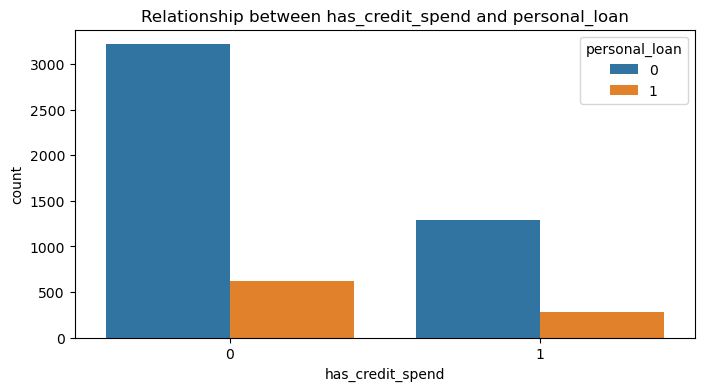

In [23]:
# Show count plots for newly re-cast categorical features
for feat in categorical_feats:

    # Create count plot
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_loan_data, x=feat, hue=target_variable)
    plt.title('Relationship between {} and {}'.format(feat, target_variable))
    plt.show()

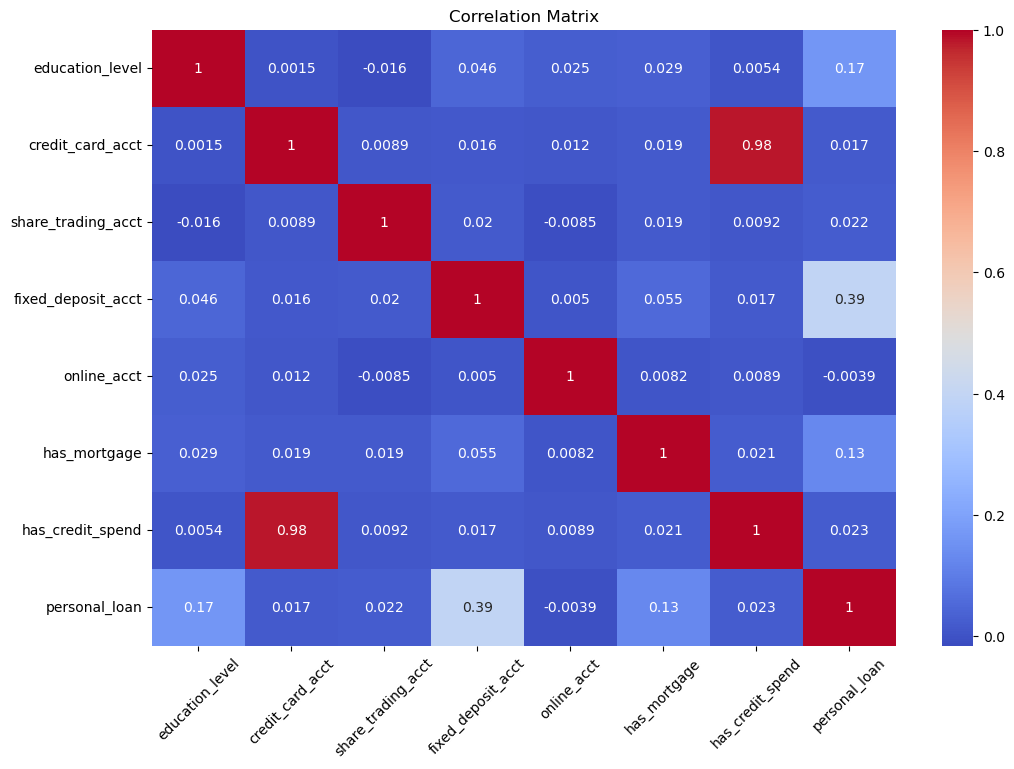

In [24]:
# Explore the correlations between categorical features (and the target)
# Note that this is only doable for all categorical features because they could be sensibly re-cast as numeric
correlation_matrix = df_loan_data[categorical_feats + [target_variable]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

# Final hypotheses:

Given the strong correlations between the variables [income, fixed_deposit_acct, has_credit_spend] and the target, it is likely the main business advice will be to target people who have all/some of the following qualities (depending how wide a net is desired to be cast): have credit card spend, have a fixed deposit account, and are high-income